In [55]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from dataset import QuickDrawDataset
from tqdm import tqdm

### Abstract
TODO

### Load Dataset

In [83]:
train_set = QuickDrawDataset(root="/data_", train=True, download=False)
test_set = QuickDrawDataset(root="/data", train=False, download=False)

[quickdraw dataset: root=/data_, train=True, download=False]
[quickdraw dataset: root=/data, train=False, download=False]


Split train dataset into train and validation

In [84]:
train_set, val_set = random_split(train_set, [0.25, 0.75])

In [85]:
batch_size = 128
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [86]:
for x, y in train_set:
    print(x.shape) # (N=1, H=28, W=28)
    break

torch.Size([1, 28, 28])


### Labels for Dataset

In [87]:
categories = QuickDrawDataset.categories()
num_categories = len(categories)
len(categories)

345

### Visualize Dataset
What does an airplane look like?

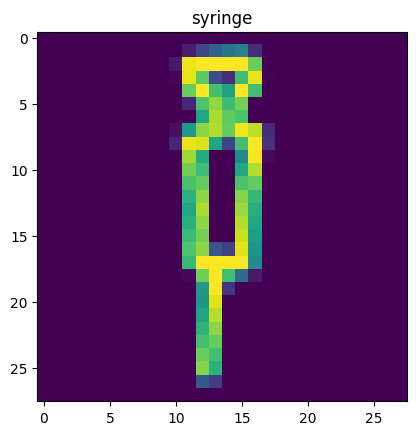

In [88]:
img, label = train_set[1002]
category = categories[label]
plt.title(category)
plt.imshow(img[0])

### Define Model
MiniAlexNet: TODO

In [89]:
class MiniAlexNet(nn.Module):
    def __init__(self, labels=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            
            nn.Conv2d(96, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.nn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(6400, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, labels),
        )

        self.init_bias()

    def init_bias(self):
        # with torch.no_grad():
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)

    def forward(self, x):
        x = self.conv(x)

#         print(x.shape)
        x = x.reshape(x.size(0), -1)

        # print(x.shape)
        x = self.nn(x)

        return x

In [90]:
device = torch.device("mps")
# device = "cpu"
minialexnet = MiniAlexNet(labels=num_categories).to(device)
minialexnet

MiniAlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (nn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (

### Define Loss & Optimizer

In [91]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(minialexnet.parameters(), weight_decay=0.0005, momentum=0.9, lr=0.01)

### Train Model

In [92]:
num_train_batches = len(train_dataloader)
num_train_batches

674

In [93]:
def evaluate(model, dataloader, criterion):
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss    

In [94]:
epochs = 30
train_losses = []
val_losses = []

print("Training")
for epoch in range(epochs):
    # set mode to train
    minialexnet.train()
    
    total_loss = 0
    for i, (X, Y) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} of {epochs}", leave=True)):
        pred = minialexnet(X.to(device))
        loss = cross_entropy(pred, Y.to(device))
        
        total_loss += loss.item()
        
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # average loss over batches
    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    
    # evaluate model on validation set
    val_loss = evaluate(minialexnet, dataloader=test_dataloader, criterion=cross_entropy)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss} Val Loss: {val_loss}")

Training


Epoch 1 of 30: 100%|██████████████████████████| 674/674 [00:46<00:00, 14.52it/s]


Epoch [1/30], Loss: 5.8303837507344145 Val Loss: 5.724872765717683


Epoch 2 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.81it/s]


Epoch [2/30], Loss: 5.088579815997568 Val Loss: 4.3466652587608055


Epoch 3 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.89it/s]


Epoch [3/30], Loss: 3.835592691551684 Val Loss: 3.293360153834025


Epoch 4 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.83it/s]


Epoch [4/30], Loss: 3.0297796397251617 Val Loss: 2.8749250924145735


Epoch 5 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.86it/s]


Epoch [5/30], Loss: 2.6130726514301243 Val Loss: 2.4306963638023094


Epoch 6 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.97it/s]


Epoch [6/30], Loss: 2.347962379278698 Val Loss: 2.300361262427436


Epoch 7 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.93it/s]


Epoch [7/30], Loss: 2.1575733361329097 Val Loss: 2.1250623332129583


Epoch 8 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.87it/s]


Epoch [8/30], Loss: 1.9992028800245563 Val Loss: 2.141807759249652


Epoch 9 of 30: 100%|██████████████████████████| 674/674 [00:45<00:00, 14.96it/s]


Epoch [9/30], Loss: 1.8698797639824163 Val Loss: 2.013034224510193


Epoch 10 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.97it/s]


Epoch [10/30], Loss: 1.7702109017782466 Val Loss: 1.9857266125855622


Epoch 11 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.90it/s]


Epoch [11/30], Loss: 1.6579482443962323 Val Loss: 1.968271189265781


Epoch 12 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.75it/s]


Epoch [12/30], Loss: 1.5625419193983785 Val Loss: 1.9369182542518333


Epoch 13 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.87it/s]


Epoch [13/30], Loss: 1.4822209258107828 Val Loss: 1.9615590307447646


Epoch 14 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.70it/s]


Epoch [14/30], Loss: 1.396761043312288 Val Loss: 1.9531227350234985


Epoch 15 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.72it/s]


Epoch [15/30], Loss: 1.3231923398879586 Val Loss: 1.939957234594557


Epoch 16 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.67it/s]


Epoch [16/30], Loss: 1.2547041969235644 Val Loss: 1.9527773636358756


Epoch 17 of 30: 100%|█████████████████████████| 674/674 [00:44<00:00, 14.98it/s]


Epoch [17/30], Loss: 1.1798127463380377 Val Loss: 1.9994868260842782


Epoch 18 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.88it/s]


Epoch [18/30], Loss: 1.1186070645598347 Val Loss: 2.0395088813923024


Epoch 19 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.83it/s]


Epoch [19/30], Loss: 1.0557149967913813 Val Loss: 2.041482576617488


Epoch 20 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.75it/s]


Epoch [20/30], Loss: 0.9894776918237217 Val Loss: 2.124194043653983


Epoch 21 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.74it/s]


Epoch [21/30], Loss: 0.9397111872006595 Val Loss: 2.130117239775481


Epoch 22 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.92it/s]


Epoch [22/30], Loss: 0.8903575047452655 Val Loss: 2.0981616664815834


Epoch 23 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.87it/s]


Epoch [23/30], Loss: 0.8411525750549328 Val Loss: 2.142558053687767


Epoch 24 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.97it/s]


Epoch [24/30], Loss: 0.7889917338991024 Val Loss: 2.2424219802573875


Epoch 25 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.97it/s]


Epoch [25/30], Loss: 0.7509777626404069 Val Loss: 2.234814268571359


Epoch 26 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.98it/s]


Epoch [26/30], Loss: 0.712172778936805 Val Loss: 2.282156714686641


Epoch 27 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.98it/s]


Epoch [27/30], Loss: 0.6805925341848096 Val Loss: 2.280840273256655


Epoch 28 of 30: 100%|█████████████████████████| 674/674 [00:45<00:00, 14.98it/s]


Epoch [28/30], Loss: 0.6400280363570335 Val Loss: 2.340481749287358


Epoch 29 of 30: 100%|█████████████████████████| 674/674 [00:44<00:00, 14.98it/s]


Epoch [29/30], Loss: 0.6109296904561782 Val Loss: 2.3103014804698803


Epoch 30 of 30: 100%|█████████████████████████| 674/674 [00:44<00:00, 14.98it/s]


Epoch [30/30], Loss: 0.5864452214287014 Val Loss: 2.3744424184163413


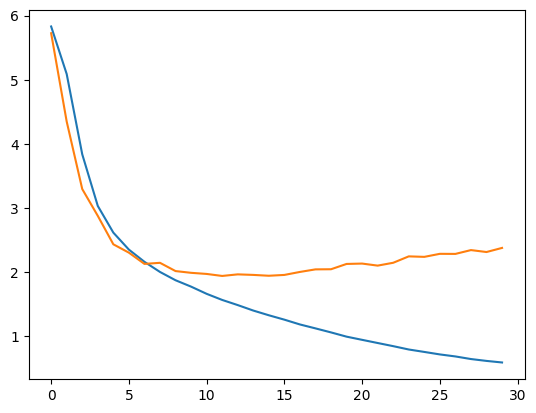

In [96]:
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), val_losses)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

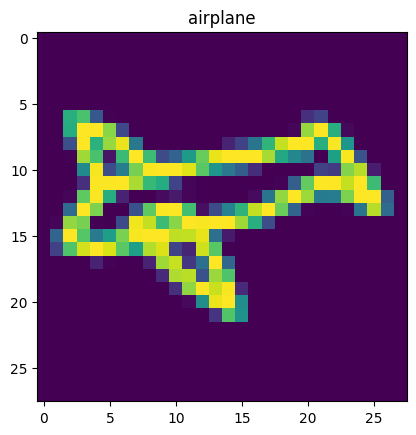

In [27]:
i = 101
img, label = train_set[i]
# print(img.shape)

plt.title(categories[label])
plt.imshow(img[0])

img = img.unsqueeze(0)

out = minialexnet(img)

print(out)

torch.argmax(out)

print(categories[label])

### Evaluate Model